- Deep Learning, Neural network: Cognitive -> Computer Vision, Natural Language Processing,...

- Boosting: Tabular --> Decision Making, Inferences

### Ensemble Learning

- Bagging: Boostrap Aggreation, Random Forest --> High variance, low bias --> Low variance, low bias
- Boosting: Gradient Boosting --> Low variance, High bias --> Low variance, low bias
- Stacking: Stack many different ML algorithms

Error = Bias^2 + Variance + Irreducible Error

#### Random Forest
- Row sampling + Column Sampling + Aggragation

Feature engineering:
- Feature Extraction
- Feature Selection
- Feature Creation

In [1]:
import numpy as np

In [ ]:
E = - Summation (P * Log (P))

In [3]:
p1 = 0.9
p0 = 1 - p1

- p1 * np.log(p1) - p0*np.log(p0)

0.3250829733914482

In [4]:
p1 = 0.6
p0 = 1 - p1

- p1 * np.log(p1) - p0*np.log(p0)

0.6730116670092565

In [5]:
p1 = 0.5
p0 = 1 - p1

- p1 * np.log(p1) - p0*np.log(p0)

0.6931471805599453

### Dataset

Predict default/ credit risk probability

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../Lecture/4.Ensemble_learning/cs-training.csv', index_col=0)
df.head(2)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0


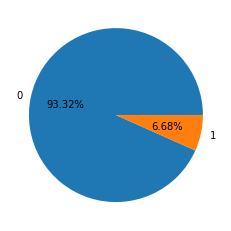

In [3]:
# _, ax = plt.figure(figsize=(20, 6))
# sns.countplot(df.SeriousDlqin2yrs, ax=ax[0])
plt.pie(df.SeriousDlqin2yrs.value_counts().values, 
        labels=df.SeriousDlqin2yrs.value_counts().index, autopct='%.2f%%')
plt.show()

In [5]:
df.SeriousDlqin2yrs.value_counts()

0    139974
1     10026
Name: SeriousDlqin2yrs, dtype: int64

In [7]:
df.shape

(150000, 11)

### Train test split

In [6]:
from sklearn.model_selection import train_test_split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='SeriousDlqin2yrs'), df.SeriousDlqin2yrs, test_size=0.1, shuffle=True,
                                                   stratify=df.SeriousDlqin2yrs)
valid_size = y_test.shape[0] / y_train.shape[0]

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=valid_size, shuffle=True, stratify=y_train)

In [10]:
X_train.shape, X_test.shape, X_valid.shape

((120000, 10), (15000, 10), (15000, 10))

In [15]:
df.SeriousDlqin2yrs.value_counts(True)

0    0.93316
1    0.06684
Name: SeriousDlqin2yrs, dtype: float64

In [12]:
y_train.value_counts(True)

0    0.933167
1    0.066833
Name: SeriousDlqin2yrs, dtype: float64

In [13]:
y_test.value_counts(True)

0    0.933133
1    0.066867
Name: SeriousDlqin2yrs, dtype: float64

In [14]:
y_valid.value_counts(True)

0    0.933133
1    0.066867
Name: SeriousDlqin2yrs, dtype: float64

### LGB Model

In [16]:
train_data = lgb.Dataset(X_train, y_train)
valid_data = lgb.Dataset(X_valid, y_valid)
test_data = lgb.Dataset(X_test, y_test)

In [38]:
params = {'objective': 'binary',
          'boosting': 'gbdt',
          'metric': ['binary_logloss', 'auc'],
          'num_leaves': 8,
          'min_data_in_leaf': 1500,
          'max_depth': 5
        }

eval_result = {}
bst = lgb.train(params, train_data, valid_sets=[train_data, valid_data], 
                evals_result=eval_result, num_boost_round=100, verbose_eval=False)

[LightGBM] [Info] Number of positive: 8020, number of negative: 111980
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004157 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 976
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.066833 -> initscore=-2.636382
[LightGBM] [Info] Start training from score -2.636382
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


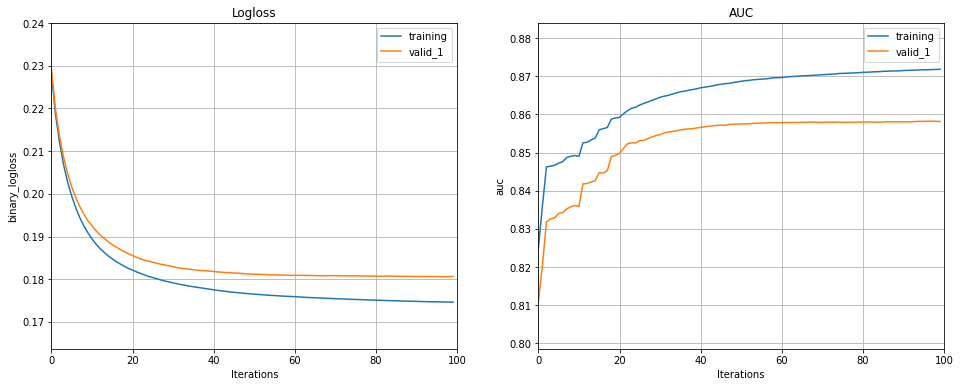

In [39]:
_, ax = plt.subplots(1, 2, figsize=(16, 6))

lgb.plot_metric(eval_result, metric='binary_logloss', ax=ax[0], title="Logloss")
lgb.plot_metric(eval_result, metric='auc', ax=ax[1], title="AUC")
plt.show()

![image.png](https://i2.wp.com/sefiks.com/wp-content/uploads/2020/12/roc-curve-original.png?fit=726%2C576&ssl=1)
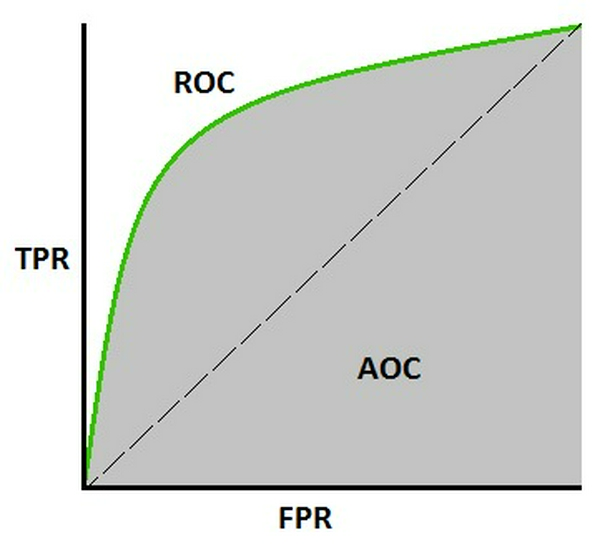

In [43]:
roc_auc_score(y_test, bst.predict(X_test))

0.8601890264051028

In [44]:
y_predicted = bst.predict(X_test)
y_predicted

array([0.09504779, 0.03530466, 0.03045768, ..., 0.0073515 , 0.02196448,
       0.00923505])

### Calibration model

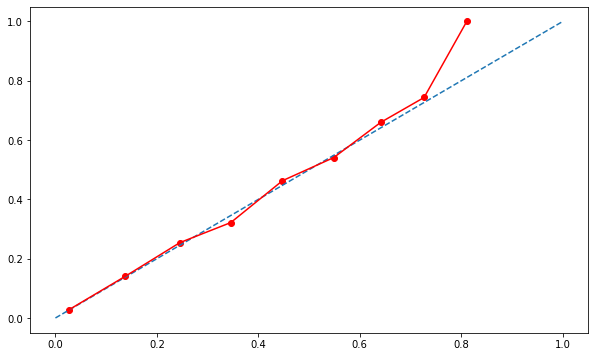

In [50]:
y_true, y_prob = calibration_curve(y_test, y_predicted, n_bins=10)

_, ax = plt.subplots(1, 2, figsize=(20, 6))

ax[0].plot([0, 1], [0, 1], linestyle='--')
ax[0].scatter(y_prob, y_predicted, color='red')
ax[0].plot(y_prob, y_true, color='red')


ax[1].plot([0, 1], [0, 1], linestyle='--')
ax[1].scatter(y_prob, y_true, color='red')
ax[1].plot(y_prob, y_true, color='red')
plt.show()

### Conversion rate

In [45]:
def conversion_rate(y_true, y_predicted, top=0.1):
    df = pd.DataFrame({'actual': y_true, 'predicted': y_predicted})
    df.sort_values('predicted', ascending=False, inplace=True)
    
    if isinstance(top, float):
        top = int(df.shape[0] * top)
        
    top_df = df.head(top)
    
    return top_df.actual.sum() / top_df.shape[0]

In [46]:
conversion_rate(y_test, y_predicted) * 100

36.86666666666667

In [32]:
from seaborn import load_dataset
import seaborn as sns

In [30]:
iris = load_dataset('iris')

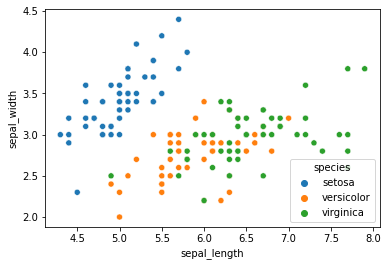

In [33]:
sns.scatterplot(data=iris, x='sepal_length', y='sepal_width', hue='species');